In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [2]:
from fastai import *
from fastai.vision import *
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
tqdm.pandas()

In [4]:
path_template = "s3://autofocus/lpz_data/labels_2012_2016_2017__{}.parquet"

In [5]:
train_df = pd.read_parquet(path_template.format("train"))
train_df.head()

,date,tags,location,is_val
path,,,,
/autofocus/data/lpz_2012-2014/raw/FA12/DPT/D02-HUP1/D02-HUP1-FA12 (10).JPG,2012-10-10,[],HUP1,False
/autofocus/data/lpz_2012-2014/raw/FA12/DPT/D02-HUP1/D02-HUP1-FA12 (100).JPG,2012-10-12,[bird],HUP1,False
/autofocus/data/lpz_2012-2014/raw/FA12/DPT/D02-HUP1/D02-HUP1-FA12 (1000).JPG,2012-10-29,[bird],HUP1,False
/autofocus/data/lpz_2012-2014/raw/FA12/DPT/D02-HUP1/D02-HUP1-FA12 (1001).JPG,2012-10-29,[bird],HUP1,False
/autofocus/data/lpz_2012-2014/raw/FA12/DPT/D02-HUP1/D02-HUP1-FA12 (1002).JPG,2012-10-29,[bird],HUP1,False


In [6]:
val_df = pd.read_parquet(path_template.format("val"))
val_df.head()

,date,tags,location,is_val
path,,,,
/autofocus/data/lpz_2012-2014/raw/FA12/DPT/D03-AFP1/D03-AFP1-FA12 (111).JPG,2012-10-12,[dog],AFP1,True
/autofocus/data/lpz_2012-2014/raw/FA12/DPT/D03-AFP1/D03-AFP1-FA12 (112).JPG,2012-10-12,[dog],AFP1,True
/autofocus/data/lpz_2012-2014/raw/FA12/DPT/D03-AFP1/D03-AFP1-FA12 (113).JPG,2012-10-12,[dog],AFP1,True
/autofocus/data/lpz_2012-2014/raw/FA12/DPT/D03-AFP1/D03-AFP1-FA12 (114).JPG,2012-10-12,[],AFP1,True
/autofocus/data/lpz_2012-2014/raw/FA12/DPT/D03-AFP1/D03-AFP1-FA12 (115).JPG,2012-10-12,[dog],AFP1,True


In [7]:
df = pd.concat((train_df, val_df))

In [8]:
df.loc[:, "tags"].apply(lambda alist: tuple(alist)).value_counts(normalize=True)

()                                      0.467658
(human,)                                0.243980
(squirrel,)                             0.075106
(bird,)                                 0.045253
(raccoon,)                              0.039863
(deer,)                                 0.026116
(dog,)                                  0.025883
(opossum,)                              0.023963
(rabbit,)                               0.015722
(coyote,)                               0.012527
(skunk,)                                0.006390
(cat,)                                  0.005245
(human, dog)                            0.005087
(rat,)                                  0.001618
(mouse,)                                0.001556
(chipmunk,)                             0.001145
(fox,)                                  0.000932
(bird, squirrel)                        0.000487
(opossum, raccoon)                      0.000302
(beaver_muskrat_woodchuck,)             0.000185
(squirrel, rabbit)  

In [9]:
data = (
    ImageList.from_df(df=df.reset_index(), path="/", cols="path")
    .split_from_df("is_val")
    .label_from_df("tags")
    .transform(get_transforms(), size=64)
    .databunch(bs=256)
    .normalize(imagenet_stats)
)

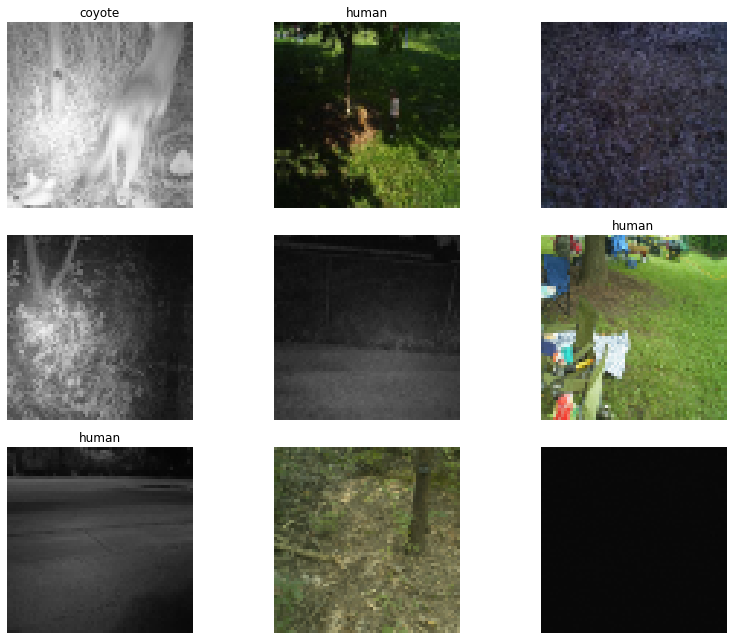

In [10]:
data.show_batch(rows=3, figsize=(12, 9))

In [11]:
arch = models.resnet34

In [16]:
learn = cnn_learner(
    data,
    arch,
    metrics=[
        partial(accuracy_thresh, thresh=0.5),
        partial(accuracy_thresh, thresh=0.2),
        partial(fbeta, thresh=0.5, beta=0.5),
        partial(fbeta, thresh=0.2, beta=0.5),
    ],
    path="models",
)

In [18]:
learn.data

ImageDataBunch;

Train: LabelList (134849 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultiCategoryList
,bird,bird,bird,bird
Path: /;

Valid: LabelList (10999 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: MultiCategoryList
dog,dog,dog,,dog
Path: /;

Test: None

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


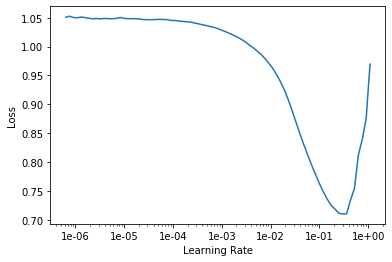

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(1, 3e-2)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.064958,0.075927,0.979246,0.965426,0.107752,0.198389,05:24


In [21]:
learn.save("test")

In [22]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


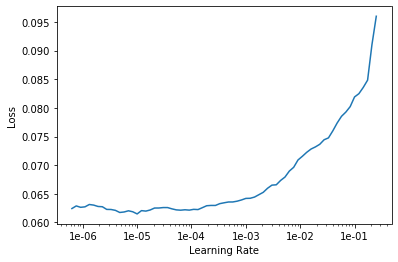

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(1, 2e-5)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.058968,0.072285,0.979766,0.965350,0.120188,0.199082,05:11


In [25]:
learn.fit_one_cycle(1, 2e-5)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.057355,0.071685,0.979917,0.957314,0.128264,0.201861,05:11


In [26]:
learn.data = (
    ImageList.from_df(df=df.reset_index(), path="/", cols="path")
    .split_from_df("is_val")
    .label_from_df("tags")
    .transform(get_transforms(), size=128)
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

In [27]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


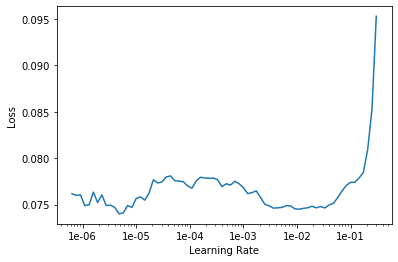

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.056117,0.065568,0.980817,0.959607,0.162131,0.229618,06:48


epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


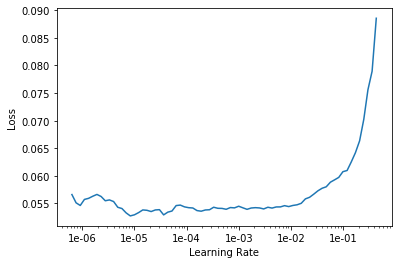

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.054690,0.066286,0.981448,0.958769,0.166157,0.232199,06:49


In [32]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


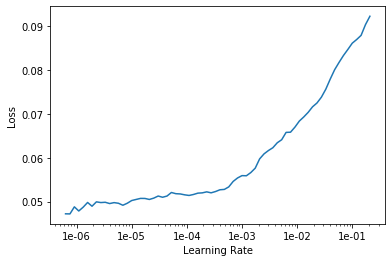

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(1, 3e-5)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.049793,0.062637,0.982134,0.960875,0.180047,0.250406,06:51


In [35]:
learn.save("checkpoint1")

In [36]:
learn.data = (
    ImageList.from_df(df=df.reset_index(), path="/", cols="path")
    .split_from_df("is_val")
    .label_from_df("tags")
    .transform(get_transforms(), size=224)
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

In [37]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


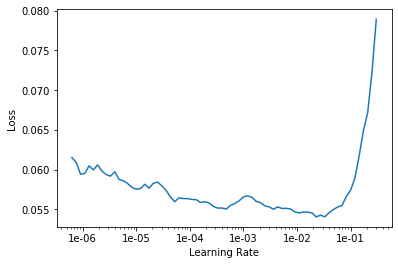

In [38]:
learn.lr_find()
learn.recorder.plot()

In [39]:
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.048673,0.057481,0.983428,0.964669,0.202675,0.262790,11:48


In [40]:
learn.save("checkpoint2")

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


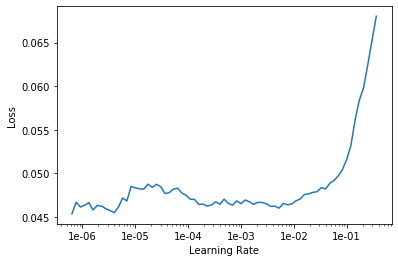

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.044845,0.056675,0.982988,0.971189,0.213252,0.269167,11:46


In [43]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


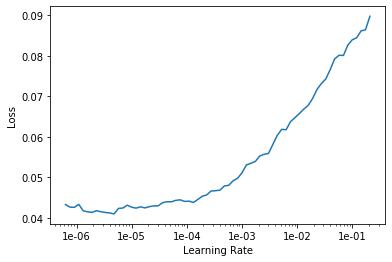

In [44]:
learn.lr_find()
learn.recorder.plot()

In [45]:
learn.fit_one_cycle(3, 2e-5)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.044544,0.053365,0.984620,0.972816,0.224121,0.274879,11:51
1,0.039259,0.051339,0.985347,0.970982,0.235764,0.286084,11:51
2,0.037045,0.050551,0.984352,0.977225,0.234476,0.291346,11:52


In [46]:
learn.save("checkpoint3")

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


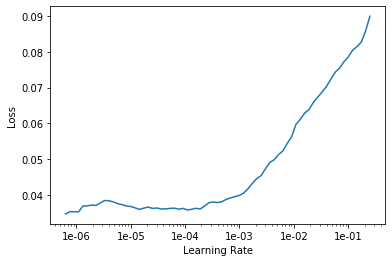

In [47]:
learn.lr_find()
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(1, 2e-5)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.037158,0.050683,0.984746,0.975891,0.236547,0.287851,11:53


In [49]:
learn.save("checkpoint4")

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


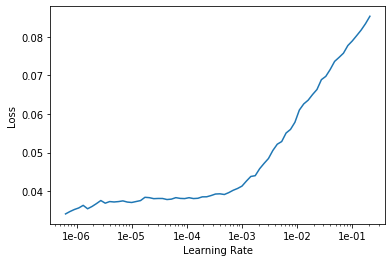

In [50]:
learn.lr_find()
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.037023,0.051399,0.984428,0.977195,0.241764,0.288006,11:51


epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


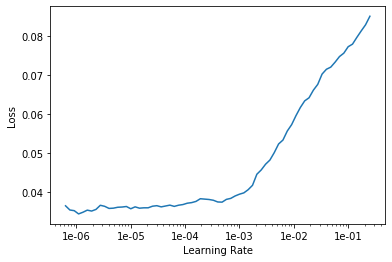

In [52]:
learn.lr_find()
learn.recorder.plot()

In [53]:
learn.fit_one_cycle(3, 3e-5)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.038690,0.051080,0.985458,0.967638,0.244684,0.292763,11:51
1,0.034617,0.046135,0.986236,0.978897,0.253220,0.300816,11:53
2,0.031943,0.046935,0.985878,0.979256,0.250735,0.297434,11:52


In [54]:
learn.save("checkpoint5")

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


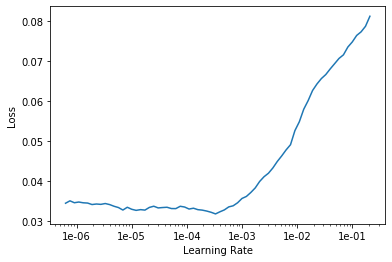

In [55]:
learn.lr_find()
learn.recorder.plot()

In [56]:
learn.fit_one_cycle(3, 3e-5)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.033635,0.048577,0.985776,0.974371,0.254750,0.297482,11:55
1,0.031226,0.045975,0.986574,0.979220,0.257458,0.303533,11:55
2,0.030388,0.044776,0.986433,0.980043,0.259791,0.306001,11:53


In [57]:
learn.save("checkpoint5")

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


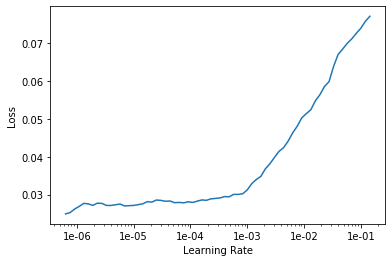

In [58]:
learn.lr_find()
learn.recorder.plot()

In [59]:
learn.fit_one_cycle(3, 3e-5)

epoch,train_loss,valid_loss,accuracy_thresh,accuracy_thresh,fbeta,fbeta,time
0,0.032182,0.050513,0.985908,0.973887,0.254215,0.296511,11:53


KeyboardInterrupt: 

In [60]:
learn.load("checkpoint5")

Learner(data=ImageDataBunch;

Train: LabelList (134849 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
,bird,bird,bird,bird
Path: /;

Valid: LabelList (10999 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: MultiCategoryList
dog,dog,dog,,dog
Path: /;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (re

In [61]:
learn.export()